<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Baseline_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SETUP

In [25]:
#import os
#import tensorflow as tf
#import numpy as np
#import random as rn

#os.environ['PYTHONHASHSEED'] = '0'
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
#np.random.seed(37)
#tf.random.set_seed(89)

#import numpy as np
#import os
#import random
#import tensorflow as tf # 2.2.0

#SEED = 42
#os.environ['PYTHONHASHSEED']=str(SEED)
#os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1+
#np.random.seed(SEED)
#random.seed(SEED)
#tf.random.set_seed(SEED)

In [26]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


DATA PROCESSING

In [28]:
train_dir = '/content/drive/My Drive/Colab Notebooks/charts/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/charts/Validation'

In [29]:
img_width, img_height = 224, 224 
nb_train_samples = 560
nb_validation_samples = 140
epochs = 100
batch_size = 16

In [30]:
#checking whether the rgb channel is first or last to feed the input shape accordingly
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [31]:
#Experimental block of code for hsv - has issues with range (0-255) which will not produce efficient training
import cv2
import numpy as np
from PIL import Image
def myFunc(image):
    image = np.array(image)
    hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    hsv_image = hsv_image.astype('float32')
    hsv_image = hsv_image / 255.0
    return Image.fromarray(hsv_image)

In [32]:
#Performing augmentation on image scaling, zoom and flipping so that the network has more training samples
train_datagen = ImageDataGenerator( 
	rescale=1. / 255, 
	shear_range=0.2, 
	zoom_range=0.2, 
	channel_shift_range=150.0,
	brightness_range=(0.3,0.9) #Range starts from 0.3 so that the images dont become too dark for the model to recognize
	#preprocessing_function=myFunc
	) 

#Not having any augmentation apart from scaling as the validation data should resemble the real-world data as close as possible
val_datagen = ImageDataGenerator(rescale=1. / 255,
                                 #preprocessing_function=myFunc
																                 ) 

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [33]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

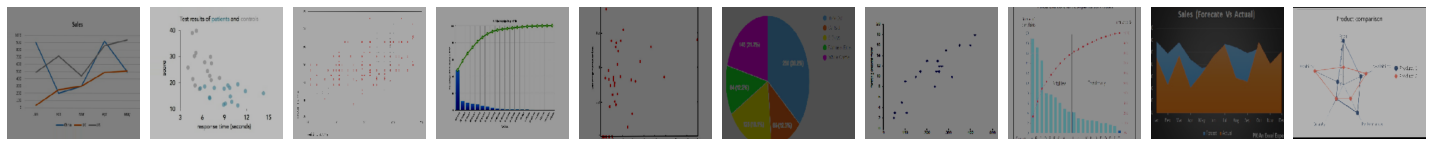

In [34]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:10])

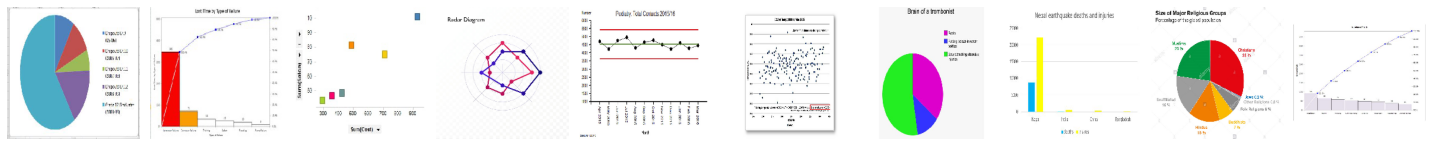

In [35]:
sample_val_images, _ = next(validation_generator)
plotImages(sample_val_images[:10])

In [36]:
# 3 CNN blocks containing a max pooling layer in each of them. On top of that is a fully connected layer with relu activation function
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(7, activation='softmax') #Nodes in the final dense layer should be equal to number of classes + softmax activation
])


In [37]:
lr=0.001
model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr) ,
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)            

In [38]:
#Since data aug is applied only to training and not on validation set, there might be epochs where the validation accuracy will be greater than
#the training accuracy in the initial few epochs
history = model.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 1/100
35/35 [==============================] - 210s 6s/step - loss: 2.1138 - accuracy: 0.2714 - val_loss: 1.4371 - val_accuracy: 0.3984
Epoch 2/100
35/35 [==============================] - 13s 379ms/step - loss: 1.2888 - accuracy: 0.5161 - val_loss: 1.6851 - val_accuracy: 0.4531
Epoch 3/100
35/35 [==============================] - 13s 379ms/step - loss: 1.0631 - accuracy: 0.5946 - val_loss: 1.3768 - val_accuracy: 0.4844
Epoch 4/100
35/35 [==============================] - 13s 377ms/step - loss: 0.9150 - accuracy: 0.6536 - val_loss: 1.3916 - val_accuracy: 0.6719
Epoch 5/100
35/35 [==============================] - 13s 380ms/step - loss: 0.7675 - accuracy: 0.7143 - val_loss: 1.4507 - val_accuracy: 0.6797
Epoch 6/100
35/35 [==============================] - 13s 380ms/step - loss: 0.6969 - accuracy: 0.7625 - val_loss: 1.5190 - val_accuracy: 0.6250
Epoch 7/100
35/35 [==============================] - 14s 391ms/step - loss: 0.6771 - accuracy: 0.7589 - val_loss: 1.2850 - val_accuracy: 0

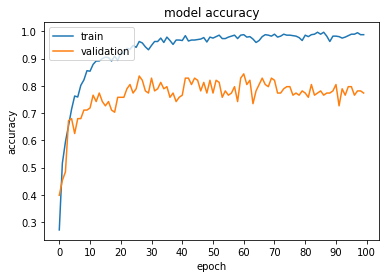

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

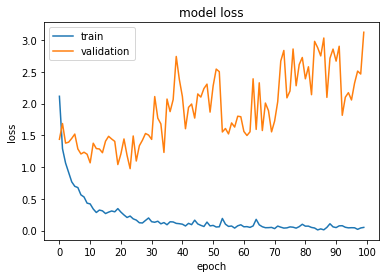

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,110, 10))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Learning scheduling - to improve performance

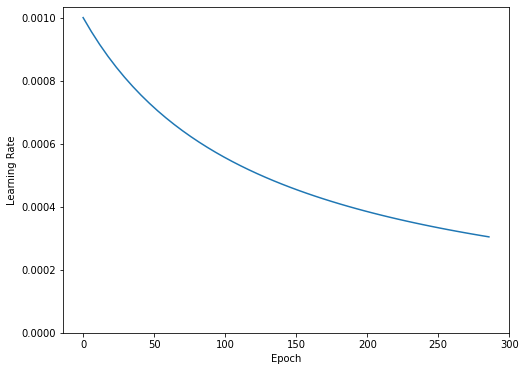

In [41]:
STEPS_PER_EPOCH = nb_train_samples // batch_size

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=8,
  staircase=False)

step = np.linspace(0,10000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


In [42]:
model.compile(optimizer=keras.optimizers.Adam(lr_schedule) ,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)            

In [43]:
#Since data aug is applied only to training and not on validation set, there might be epochs where the validation accuracy will be greater than
#the training accuracy in the initial few epochs
history2 = model.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=epochs, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 1/100
35/35 [==============================] - 14s 399ms/step - loss: 0.1328 - accuracy: 0.9714 - val_loss: 2.1710 - val_accuracy: 0.8047
Epoch 2/100
35/35 [==============================] - 14s 395ms/step - loss: 0.0865 - accuracy: 0.9857 - val_loss: 2.6997 - val_accuracy: 0.7656
Epoch 3/100
35/35 [==============================] - 14s 394ms/step - loss: 0.0536 - accuracy: 0.9857 - val_loss: 2.2325 - val_accuracy: 0.7812
Epoch 4/100
35/35 [==============================] - 14s 396ms/step - loss: 0.0340 - accuracy: 0.9911 - val_loss: 2.6251 - val_accuracy: 0.7891
Epoch 5/100
35/35 [==============================] - 14s 408ms/step - loss: 0.0321 - accuracy: 0.9911 - val_loss: 2.9506 - val_accuracy: 0.8047
Epoch 6/100
35/35 [==============================] - 14s 391ms/step - loss: 0.0193 - accuracy: 0.9946 - val_loss: 5.7247 - val_accuracy: 0.7656
Epoch 7/100
35/35 [==============================] - 14s 392ms/step - loss: 0.1230 - accuracy: 0.9643 - val_loss: 3.6146 - val_accuracy:

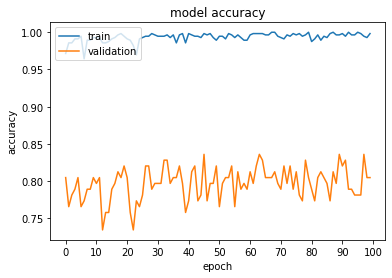

In [44]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.xticks(np.arange(0,110, 10))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

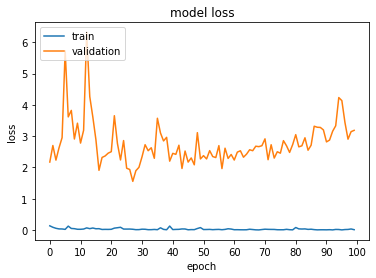

In [45]:
# summarize history for loss https://www.kaggle.com/prateek0x/multiclass-image-classification-using-keras
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,110, 10))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [46]:
print(validation_generator.class_indices)

{'AreaChart': 0, 'BarChart': 1, 'LineChart': 2, 'ParetoChart': 3, 'PieChart': 4, 'RadarChart': 5, 'ScatterPlot': 6}


In [47]:
final_loss, final_accuracy = model.evaluate(validation_generator, steps = nb_validation_samples // batch_size)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

8/8 [==============================] - 1s 111ms/step - loss: 3.0336 - accuracy: 0.8125
Final loss: 3.03
Final accuracy: 81.25%


In [48]:
np.mean(history.history['val_accuracy']) *100

76.515625

In [49]:
np.mean(history2.history['val_accuracy']) *100

79.6953125